In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
sb.set()
%matplotlib inline

In [2]:
REPLACE_WITH = "Sin Información"

## 1.1 Utils

In [3]:
#Variables categoricas
def ver_atributo_categorico(df,col,limit=False,lim=10,log=False,hue=None,palette=None):
    l = df[col].unique().tolist()
    l_len = len(l)
    
    if log:
        print(l_len,l)
    
    sb.set_color_codes("muted")
    if limit:
        return sb.countplot(y=col, data=df, color="r", order=df[col].value_counts().index[:lim],hue=hue,palette=palette);
    else:
        return sb.countplot(y=col, data=df, color="r", order=df[col].value_counts().index[:l_len],hue=hue,palette=palette);

# 1 Select Data

In [4]:
cot_all = pd.read_excel("..\\..\\Datos\\working\\cotizaciones_all.xlsx")
neg_all = pd.read_excel("..\\..\\Datos\\working\\negocios_all.xlsx")

In [5]:
# cot_all.columns

In [6]:
# cot_all.drop(['Etapa','Tipo de Medio','Razon Social',
# #               'Cargo', 'Situacion Laboral',
# #               'Antiguedad Laboral'
#              ],
#             axis=1,inplace=True)

In [7]:
cot_mod = cot_all.copy()

In [8]:
# ruts de los clientes en negocio
neg_ids = neg_all['ID Cotizacion'].unique().tolist()

# cot_neg = cot_all.copy()
cot_mod['Negocio'] = cot_all['ID'].isin(neg_ids)
cot_mod[cot_mod['Negocio'] == True].shape

(2336, 42)

# 2 Clean Data

In [9]:
# variables a impiar y chequear

# Limpiar variable fecha de nacimiento de alguna manera
# Limpiar variable Sexo usando rutificador
# Limpar variables Direccion usando en lo posible el rutificador y otras fuentes
# Llenar mv en decuentos con 0

## 2.1 Rut
Arreglar Ruts, luego validarlos para aplicar data crawling en rutificador.
Si el rut esta mal escrito por ende no es valido, se prosigue a buscar el rut por el nombre y arreglar el rut.
Todo esto con el find de obtener el genero, direccion, latiyud y longitud del cotizante

### 2.1.1 Funciones
Funciones para tratar los ruts

In [10]:
def format_rut(x):
    rut = x.split('-')
    l_s = list(rut[0])
    r_l = l_s[::-1]
    new = []
    i = 0
    new.append(rut[1])
    new.append('-')
    for c in r_l:
        if i==3:
            new.append('.')
            i = 0
        new.append(c)
        i +=1
    rut = ''.join(new[::-1])
    return rut

In [11]:
import chile_rut
import re

def val_rut(x):
    x = str(x)
    if len(x) == 0:
        return False
    x = re.sub('[.|!@#$]', '', x)
    
    if len(x.split('-')) >= 2:
        return chile_rut.validate_rut(x)
    else:
        x = x[:-1] + '-' + x[-1]
        return chile_rut.validate_rut(x)

def clean_rut(x):
    x = str(x)
    if len(x) == 0:
        return False
    x = re.sub('[.|!@#$]', '', x)
    
    if len(x.split('-')) >= 2:
        return x
    else:
        x = x[:-1] + '-' + x[-1]
        return x
    
cot_mod['Clean Rut'] = [clean_rut(x) for x in cot_mod['RUT'].values]
cot_mod['Valid Rut'] = [val_rut(x) for x in cot_mod['Clean Rut'].values]


### 2.1.1 Insights
Revision de los ruts, mal formaciones, ruts malos que tienen negocios, etc

In [12]:
#Eliminar indice 1704 y arreglar rut max boris
print('Ruts que hicieron negocios pero no son validos')
cot_mod[(cot_mod['Valid Rut'] == False) & (cot_mod['Negocio'] == True)][['Nombre','RUT','Negocio','Valid Rut','Clean Rut']]

Ruts que hicieron negocios pero no son validos


,Nombre,RUT,Negocio,Valid Rut,Clean Rut
7390,max boris,14030274-6,True,False,14030274-6
7504,max boris,14030274-6,True,False,14030274-6
1704,Error,15516786-8,True,False,15516786-8


In [13]:
# ver que ruts invalidos pueden ser rescatados o arreglados buscando por sus nombres
print("Ruts catalogados como invalidos, buscar por nombres")
ruts_iv = cot_mod[(cot_mod['Valid Rut'] == False)] 
print(ruts_iv.shape)

ruts_invalidos = []
for group, frame in  ruts_iv.groupby('Clean Rut'):
    ruts_invalidos.append(str(group))

s_ruts = pd.Series(ruts_invalidos)
s_ruts.to_csv("..\\..\\Datos\\ruts_invalidos_scrap.csv")

# print(ruts_iv[['Nombre','Apellido 1','RUT','Clean Rut','Valid Rut']].head())

Ruts catalogados como invalidos, buscar por nombres
(69, 44)


In [14]:
print("Ruts arreglados, estaban mal escritos y luego fueron validos.")
df = cot_mod[(cot_mod['RUT'] != cot_mod['Clean Rut']) & (cot_mod['Valid Rut'] ==True)]
print(df.shape)
print(df[['Nombre','Apellido 1','Apellido 2','RUT','Clean Rut','Valid Rut']].head(10))

Ruts arreglados, estaban mal escritos y luego fueron validos.
(1, 44)
      Nombre Apellido 1 Apellido 2        RUT   Clean Rut  Valid Rut
8  Valentina  Fernandez          .  19483862k  19483862-k       True


In [15]:
print("Ruts arreglados, estaban mal escritos y luego fueron validos.")
df = cot_mod[(cot_mod['RUT'] != cot_mod['Clean Rut']) & (cot_mod['Valid Rut'] ==False)]
print(df.shape)
print(df[['Nombre','Apellido 1','Apellido 2','RUT','Clean Rut','Valid Rut']].head(10))

Ruts arreglados, estaban mal escritos y luego fueron validos.
(6, 44)
              Nombre Apellido 1 Apellido 2           RUT   Clean Rut  \
821         Giovanni     Flores          .  16.546.158-2  16546158-2   
841         Giovanni     Flores          .  16.546.158-2  16546158-2   
3716           Mario     Concha     Concha     156778804  15677880-4   
8943    Jose Edgardo    Caamaño   Chamorro       6180535    618053-5   
9099   Dinora  Nilda      Bravo      Cerda       9559524    955952-4   
9574  Anegelo Felipe      Godoy    Morales    |7321289-5   7321289-5   

      Valid Rut  
821       False  
841       False  
3716      False  
8943      False  
9099      False  
9574      False  


In [16]:
print("Ruts que estaban bien escritos.")
df = cot_mod[(cot_mod['RUT'] == cot_mod['Clean Rut'])]
print(df.shape)

Ruts que estaban bien escritos.
(16585, 44)


In [17]:
print("Ruts que estaban bien escritos y son validos.")
df = cot_mod[(cot_mod['RUT'] == cot_mod['Clean Rut']) &(cot_mod['Valid Rut'] ==True)]
print(df.shape)

ruts_validos = []
for group, frame in  df.groupby('Clean Rut'):
    ruts_validos.append(str(group))

# print(ruts_invalidos)
ruts_validos= [format_rut(x) for x in ruts_validos]
cot_mod['Format Rut'] = [format_rut(x) for x in cot_mod['Clean Rut'].values]
s_ruts = pd.Series(ruts_validos)
s_ruts.to_csv("..\\..\\ruts_validos_scrap.csv")

Ruts que estaban bien escritos y son validos.
(16522, 44)


In [18]:
print("Ruts que estaban bien escritos pero no son validos, buscar ruts por nombres.")
df = cot_mod[(cot_mod['RUT'] == cot_mod['Clean Rut']) &(cot_mod['Valid Rut'] ==False)]
print(df.shape)

Ruts que estaban bien escritos pero no son validos, buscar ruts por nombres.
(63, 45)


### 2.1.1 Ruts Scrapped

In [19]:
#Ruts y sus datos obtenidos de forma valida
ruts_scrapped = pd.read_csv('..\\..\\DataCrawling\\rut\\ruts_validos.csv')
ruts_scrapped['RUT'] = [x.replace(' ','') for x in ruts_scrapped['RUT'].values]
ruts_scrapped['RUT'] = [x.replace('K','k') for x in ruts_scrapped['RUT'].values]
print(ruts_scrapped.shape)
print(ruts_scrapped.head(2))

(6012, 5)
                                  Name           RUT Gender  \
0   SCHNEIDER BARRERA RICARDO ERNESTO   10.023.348-7   VAR    
1     MORALES ESPINOZA CLAUDIO ANDRES   10.020.262-k   VAR    

                             Adress               Comuna  
0                J  CISTERNAS 1612            LA SERENA   
1   ALEJANDRO SEXTO 2787LZO ARENAS    CONCEPCION CENTRO   


### 2.1.1 Ruts Scrapped merge a DF principal

In [20]:
# merge
cot_mod_cp = cot_mod.copy()
cot_mod_cp['Format Rut'] = [x.replace('K','k') for x in cot_mod_cp['Format Rut'].values]
cot_merge = pd.merge(cot_mod_cp, ruts_scrapped,how='left', left_on='Format Rut', right_on='RUT')
# print(cot_merge.columns)
columns = ['Format Rut','Valid Rut','Negocio','Nombre','Apellido 1','Name','Gender','Sexo',
           'Adress','Direccion', 'Region','Provincia', 'Comuna_x', 'Comuna_y']
cot_merge[columns][cot_merge['Sexo'].isnull()].shape

(1869, 14)

In [21]:

ruts_scrapped['RUT'] = [x.replace(' ','') for x in ruts_scrapped['RUT'].values]

# df = pd.merge(cot_mod_cp,ruts_scrapped,how='outer',left_on='Format Rut',right_on='RUT')
df = pd.merge(cot_mod_cp,ruts_scrapped,how='outer',left_on='Format Rut',right_on='RUT')

ruts_scrapped.to_csv('..\\..\\Datos\\working\\ruts_scrapped_mod.csv')
df.to_excel('..\\..\\Datos\\tmp.xlsx')

## 2.2 Profesion

130 [nan, 'Empresario', 'Constructor Civil', 'Traductor e Interprete', 'Matrona', 'Odontólogo', 'Profesor', 'Ingeniería en Biotecnología', 'Otro', 'Ingeniero Eléctrico', 'Técnico en Construcción', 'Fonoaudiólogo', 'Diseño Industrial', 'Mecánico Industrial', 'Empleado Público', 'Enfermería', 'Ingeniero en Administración', 'Contador Auditor', 'Ingeniero Comercial', 'Ingeniero en Construcción', 'Ingeniero', 'Empleado', 'Agronomo', 'Prevencionista de Riesgos', 'Ingeniero Civil Química', 'Administrador', 'Ingeniero Civil Industrial', 'Nutrición y Dietética', 'Tecnólogo Médico', 'Abogado', 'Médico', 'Educadora de Párvulos', 'Administrador Público', 'Periodista', 'Ingeniero de Ejecución', 'Psicólogo', 'Arquitecto', 'Ingeniero Civil Electrónico', 'Ingeniero en Prevención de Riesgo', 'Ingeniero Civil Eléctrico', 'Vendedor', 'Pastor', 'Administración de Empresas', 'Administrativo', 'Docente', 'Ingeniero Agronomo', 'Trabajo Social', 'Ingeniero Biomédica', 'Dueña De Casa', 'Ingeniero Civil en Info

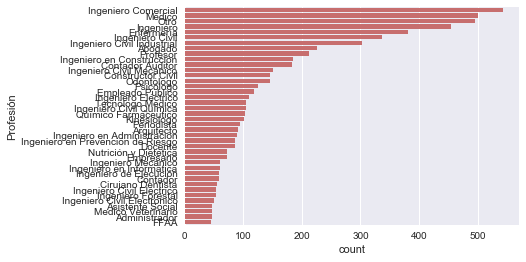

In [22]:
ver_atributo_categorico(cot_all,'Profesión',log=True, limit = True, lim=40)

9226
129


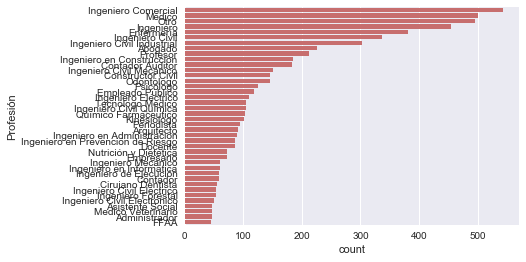

In [23]:
print(cot_mod['Profesión'].isnull().sum())
print(cot_mod['Profesión'].nunique())
ver_atributo_categorico(cot_mod,'Profesión', limit = True, lim=40)

In [24]:
print('Nulos ', cot_mod[cot_mod['Profesión'].isnull()].shape)
cot_mod['Profesión'].fillna('Sin Información', inplace=True)
print('Nulos ', cot_mod[cot_mod['Profesión'].isnull()].shape)

to_replace = ['a', '.', 'c', 'No indicado', 'No indica', 'n',
             'jdpqdp', 'no indicado', '*', 'fff', 'xxxx', 'eee', 
              'x', 'm', 'nn', 'rrr', 'wwwww', 'www', 0, 'k']

cot_mod['Profesión'].replace(
    to_replace,
    'Sin Información', inplace=True, regex=False
)

to_replace = ['\xa0']

cot_mod['Profesión'].replace(
    to_replace,
    '', inplace=True, regex=True
)


Nulos  (9226, 45)
Nulos  (0, 45)


0
130


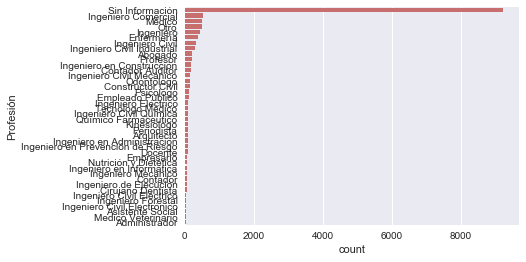

In [25]:
print(cot_mod['Profesión'].isnull().sum())
print(cot_mod['Profesión'].nunique())
ver_atributo_categorico(cot_mod,'Profesión', limit = True, lim=40)

In [26]:
# cot_mod.columns

In [27]:
cot_mod['profesion_agg'] = cot_mod['Profesión']
print('Null Profesiones ',cot_mod.profesion_agg.isnull().sum())

cot_mod['profesion_agg'].fillna('sin informacion',inplace=True)
print('Null Profesiones ',cot_mod.profesion_agg.isnull().sum())

# cot_mod['profesion_area'] = cot_mod['Profesión']

cot_prof = cot_mod[~cot_mod['Profesión'].isnull()]
cot_prof =cot_prof[['Profesión','profesion_agg','RUT']]
print(len(cot_prof.RUT.unique()))
print(len(cot_prof.profesion_agg.unique()))

Null Profesiones  0
Null Profesiones  0
6184
130


In [28]:
# # accented_string = u'Málaga'
# # # accented_string is of type 'unicode'
# import unidecode
# # unaccented_string = unidecode.unidecode(accented_string)
# # unaccented_string.lower()

# # cot_mod['profesion_agg'].fillna('sin informacion')
# # cot_mod['profesion_agg'] = [unidecode.unidecode(x).lower() for x in cot_mod['profesion_agg']]
# # # cot_mod.profesion_agg = cot_prof.profesion_agg

In [29]:
cot_prof.head()

,Profesión,profesion_agg,RUT
0,Sin Información,Sin Información,14273551-2
1,Sin Información,Sin Información,13309954-9
2,Sin Información,Sin Información,14583354-k
3,Empresario,Empresario,7188659-k
4,Constructor Civil,Constructor Civil,13377606-0


## 2.2 Estado Civil

Nulos  2049
9


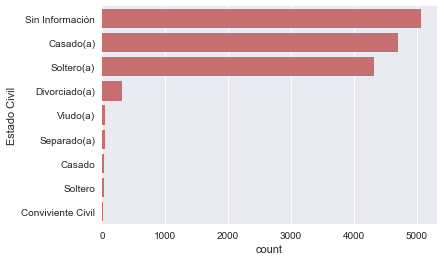

In [30]:
print('Nulos ',cot_mod['Estado Civil'].isnull().sum())
print(cot_mod['Estado Civil'].nunique())
ver_atributo_categorico(cot_mod,'Estado Civil')

In [31]:
print(cot_mod[cot_mod['Estado Civil'].isnull()].shape)
cot_mod['Estado Civil'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Estado Civil'].isnull()].shape)

(2049, 46)
(0, 46)


Nulos  0


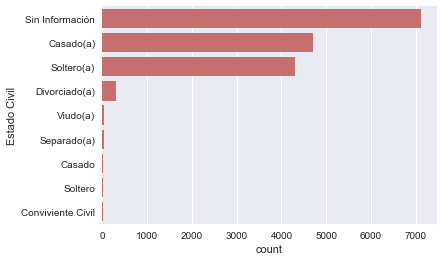

In [32]:
print('Nulos ',cot_mod['Estado Civil'].isnull().sum())
ver_atributo_categorico(cot_mod,'Estado Civil')

## 2.2 Actividad

2350
6
7 ['Tecnico', 'Empleado', 'Profesional', 'Independiente (no profesional)', nan, 'Dueña de casa', 'Estudiante']


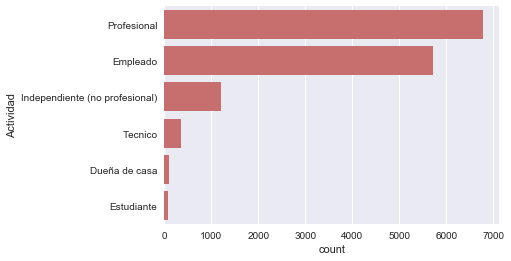

In [33]:
print(cot_mod.Actividad.isnull().sum())
print(cot_mod.Actividad.nunique())
ver_atributo_categorico(cot_mod, 'Actividad', log=True, limit = True, lim=30)

In [34]:
print(cot_mod[cot_mod['Actividad'].isnull()].shape)
cot_mod['Actividad'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Actividad'].isnull()].shape)

(2350, 46)
(0, 46)


0
7 ['Tecnico', 'Empleado', 'Profesional', 'Independiente (no profesional)', 'Sin Información', 'Dueña de casa', 'Estudiante']


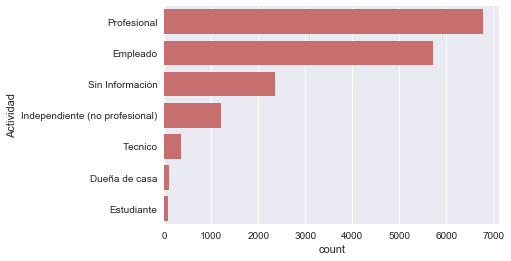

In [35]:
print(cot_mod.Actividad.isnull().sum())
ver_atributo_categorico(cot_mod, 'Actividad', log=True, limit = True, lim=30)

## 2.2 Empleador

510 [nan, 'a', 'Norteamericano / USS / UDD', 'Cesfam Lautaro Caceres', 'BioForest S.A.', 'DGAC', 'ACCIONA agua', 'Constructora Aitue \xa0\xa0\xa0', 'Arrigoni Ing.Y Const. S.A', 'Soc. Transportes Maritimo Service Ltda', 'Traumatologico', 'Besalco MD Montajes', 'Management Solutions Limitada', 'Forestal Celco', 'Caufmann', 'Inmobiliaria Los Pellines S.A.', 'MOP', '*', 'DFV Ingeniería y Gestión', 'Clinical Service', 'Hospital de Tomé', 'Municipalidad de Penco', 'Sanatorio Aleman \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0', 'Huachipato', 'Catim', 'CAP \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0', 'Municipalidad de Lota', 'Banco Estado', 'SVTI', 'Forestal papelera concepción', 'H&M Hennes & Mauritz SPA', '.', 'Chilena Consolidada seguros generales', 'Sociedad Educacional Juan Bosco LTDA', 'DAEM Hualpen', 'Ausenco Chile LTDA', 'HOSPITAL CLINICO DEL SUR SPA', 'Corporación Adventista \xa0\xa0\xa0\xa0\xa0\xa0\xa0', '\xa0\xa0

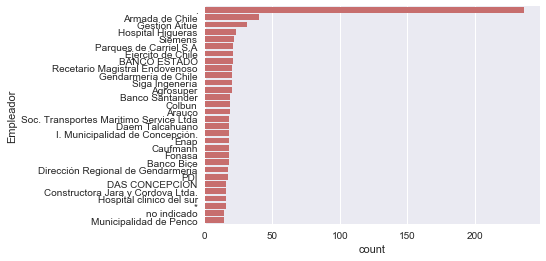

In [36]:
ver_atributo_categorico(cot_mod,'Empleador',log=True, limit = True, lim=30)

13588
509


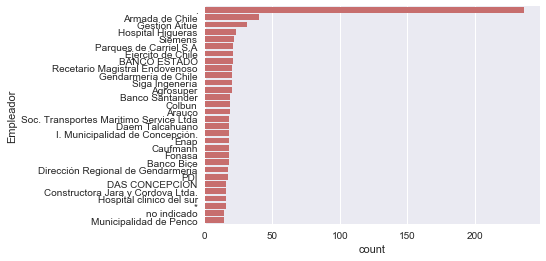

In [37]:
print(cot_mod.Empleador.isnull().sum())
print(cot_mod.Empleador.nunique())
ver_atributo_categorico(cot_mod,'Empleador',log=False, limit = True, lim=30)

In [38]:
# mask = (cot_mod['Empleador'].str.len() < 4) & (cot_mod['Empleador'].str.)
# cot_mod[mask].Empleador

In [39]:
print('Nulos ', cot_mod[cot_mod['Empleador'].isnull()].shape)
cot_mod['Empleador'].fillna('Sin Información', inplace=True)
print('Nulos ', cot_mod[cot_mod['Empleador'].isnull()].shape)

to_replace = ['a', '.', 'c', 'No indicado', 'No indica', 'n',
             'jdpqdp', 'no indicado', '*', 'fff', 'xxxx', 'eee', 
              'x', 'm', 'nn', 'rrr', 'wwwww', 'www', 0, 'k']

cot_mod['Empleador'].replace(
    to_replace,
    'Sin Información', inplace=True, regex=False
)

to_replace = ['\xa0']

cot_mod['Empleador'].replace(
    to_replace,
    '', inplace=True, regex=True
)


Nulos  (13588, 46)
Nulos  (0, 46)


0
494


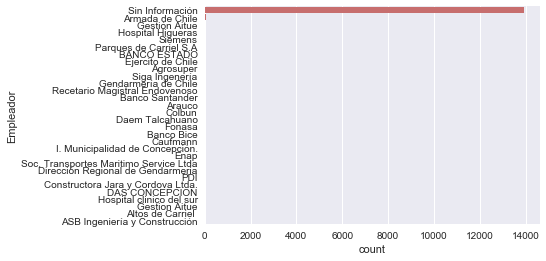

In [40]:
print(cot_mod.Empleador.isnull().sum())
print(cot_mod.Empleador.nunique())
ver_atributo_categorico(cot_mod,'Empleador',log=False, limit = True, lim=30)

## 2.2 Cargo

445 [nan, 'a', 'Profesora', 'Matrona', 'Odontologo', 'Biotecnologo', 'Metereologo', 'Ingeniero de mantención', 'Administrador de Obras', 'Vendedor Técnico', 'Enfermeria', 'Consultor Senior 2', 'Jefe de costos y presupuestos', 'Jefe área de repuestos', 'Supervisor Inmobiliario.', 'Jubilada', 'Jejfa de local', 'Ingeniero Civil', 'Ingeniero', 'Inspección técnica', 'Médico', 'Directora', 'Jefe de area', 'Psicóloga', 'Analista de control de gestión', 'enfermera de gestion', 'Ejecutivo Plataforma Normalizacion', 'Super Intendente de Terminal', 'Enfermera', 'partner manager', 'Ingeniero.', 'Ejecutivo de Negocios', '.', 'Fonoaudiólogo', 'Control de proyecto', 'ENCARGADO DE COMUNICACIONES', '\xa0\xa0\xa0\xa0', 'Chef', 'Independiente', 'Jefe Planificación', 'gerente de tienda', 'enfermera', 'vendedora', 'administrativo', 'Profesional de Obras', 'Gestor de inversiones senior', 'jefe de desarrollo', 'Pediatra', 'Medico Cirujano', 'Dueño', 'docente', 'Ingeniario civil en obras civiles', 'TENIENTE P

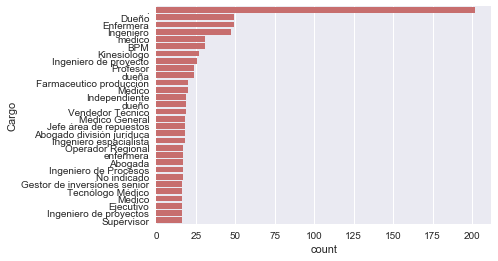

In [41]:
ver_atributo_categorico(cot_mod,'Cargo',log=True, limit = True, lim=30)

13771
444


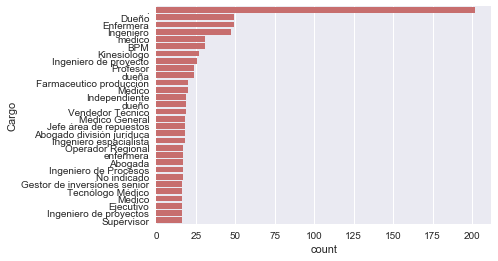

In [42]:
print(cot_mod.Cargo.isnull().sum())
print(cot_mod.Cargo.nunique())
ver_atributo_categorico(cot_mod,'Cargo',log=False, limit = True, lim=30)

In [43]:
print('Nulos ', cot_mod[cot_mod['Cargo'].isnull()].shape)
cot_mod['Cargo'].fillna('Sin Información', inplace=True)
print('Nulos ', cot_mod[cot_mod['Cargo'].isnull()].shape)

to_replace = ['a', '.', '\xa0\xa0\xa0\xa0', 'c', 'No indicado', 'No indica', 'n',
             'jdpqdp', 'no indicado', '*', 'fff', 'xxxx', 'eee']

cot_mod['Cargo'].replace(
    to_replace,
    'Sin Información', inplace=True
)

to_replace = ['\xa0']

cot_mod['Cargo'].replace(
    to_replace,
    '', inplace=True, regex=True
)

Nulos  (13771, 46)
Nulos  (0, 46)


0
432


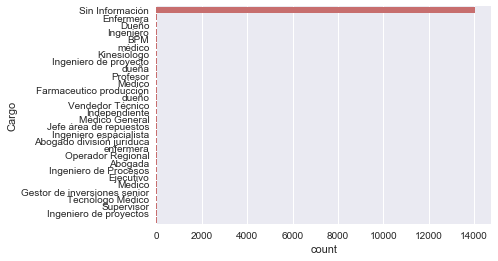

In [44]:
print(cot_mod.Cargo.isnull().sum())
print(cot_mod.Cargo.nunique())
ver_atributo_categorico(cot_mod,'Cargo',log=False, limit = True, lim=30)

## 2.2 Grupo Familiar

5964
9


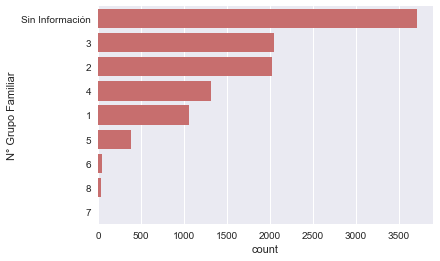

In [45]:
print(cot_mod['N° Grupo Familiar'].isnull().sum())
print(cot_mod['N° Grupo Familiar'].nunique())
ver_atributo_categorico(cot_mod,'N° Grupo Familiar',log=False, limit = True, lim=30)

In [46]:
print(cot_mod[cot_mod['N° Grupo Familiar'].isnull()].shape)
cot_mod['N° Grupo Familiar'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['N° Grupo Familiar'].isnull()].shape)

to_replace = ['\xa0']

cot_mod['N° Grupo Familiar'].replace(
    to_replace,
    '', inplace=True, regex=True
)

(5964, 46)
(0, 46)


0
9


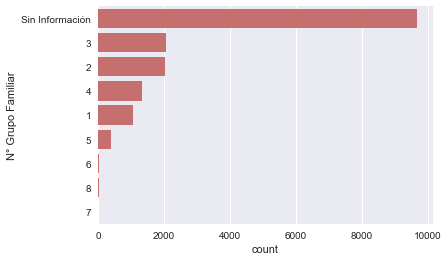

In [47]:
print(cot_mod['N° Grupo Familiar'].isnull().sum())
print(cot_mod['N° Grupo Familiar'].nunique())
ver_atributo_categorico(cot_mod,'N° Grupo Familiar',log=False, limit = True, lim=30)

## 2.2 Antiguedad Laboral

172
35
36 [0.0, 1.0, 5.0, 2.0, 29.0, 6.0, 3.0, 37.0, 7.0, 13.0, nan, 9.0, 11.0, 10.0, 15.0, 4.0, 20.0, 22.0, 12.0, 8.0, 40.0, 31.0, 18.0, 17.0, 32.0, 16.0, 27.0, 14.0, 24.0, 23.0, 33.0, 19.0, 28.0, 21.0, 30.0, 100.0]


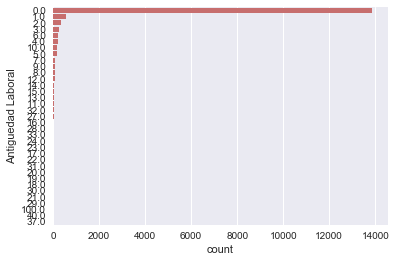

In [48]:
print(cot_mod['Antiguedad Laboral'].isnull().sum())
print(cot_mod['Antiguedad Laboral'].nunique())
ver_atributo_categorico(cot_mod,'Antiguedad Laboral',log=True)

In [49]:
print(cot_mod[cot_mod['Antiguedad Laboral'].isnull()].shape)
cot_mod['Antiguedad Laboral'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Antiguedad Laboral'].isnull()].shape)

to_replace = ['\xa0']
cot_mod['Antiguedad Laboral'].replace(
    to_replace,
    '', inplace=True, regex=True
)

(172, 46)
(0, 46)


0
36
36 [0.0, 1.0, 5.0, 2.0, 29.0, 6.0, 3.0, 37.0, 7.0, 13.0, 'Sin Información', 9.0, 11.0, 10.0, 15.0, 4.0, 20.0, 22.0, 12.0, 8.0, 40.0, 31.0, 18.0, 17.0, 32.0, 16.0, 27.0, 14.0, 24.0, 23.0, 33.0, 19.0, 28.0, 21.0, 30.0, 100.0]


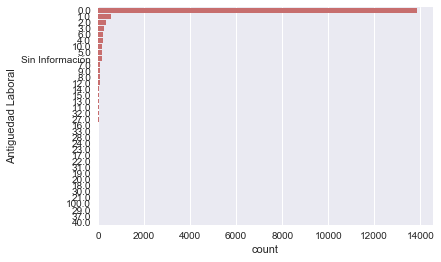

In [50]:
print(cot_mod['Antiguedad Laboral'].isnull().sum())
print(cot_mod['Antiguedad Laboral'].nunique())
ver_atributo_categorico(cot_mod,'Antiguedad Laboral',log=True)

## 2.2 Direccion

1292 ['Santo Tomas Beket 440, casa 33, Lomas San Sebastian', nan, 'Calle 1 590, Lorenzo Arenas 590', 'Pasaje la Espiga, quilamapu', 'Marina de chile \xa03098', 'Avenida San Sebastián 746 condominio don Esteban casa 05, lomas de san Sebastián. 746 Depto 05', 'Garcia Hurtado de Mendoza 525 Depto 5', 'Camino Al Venado 585', 'Laguna Lo Galindo 813 villa Ensenada 813', 'J. Valdivieso 296 Depto 34 296 Depto 34', 'Los Lirios, pasaje 37 360', 'Avenida Las Terrazas 1546 Depto Terrazas Las Lomas', 'Pasaje San Celso 9388', 'Alfredo Valenzuela 388, Villa Acero 388', 'Desiderio Garcia \xa0Higueras 756', 'Condominio Juan Antonio Varas 1664 Concepcion 1664', 'Quilacoya 9227, Villa Antillanca, Hualpén 9227', 'Lorenzo Arenas Mencia de Los Nidos 195', 'Carmen 110 Depto 216', 'La Quinta 956', 'Moises Amaral 125', 'Calle Santiago, Villa Santiago. 740', 'domingo ortiz de rozas 1470, terrazas las lomas', 'Cochrane 1384', 'Ramon Carrasco 231', 'Galbarino 2360', 'Suarez Mujica 411 Depto 801', 'Francisco de Vi

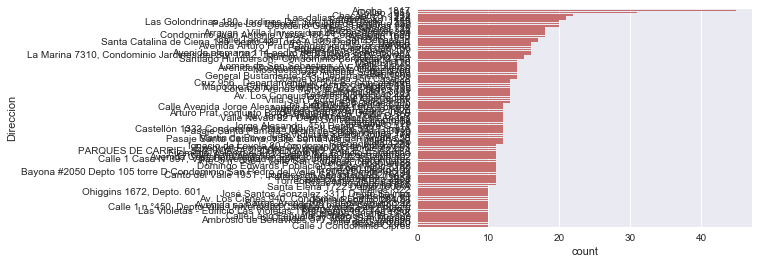

In [51]:
ver_atributo_categorico(cot_mod,'Direccion', log=True, lim=100, limit=True)

11384
1291


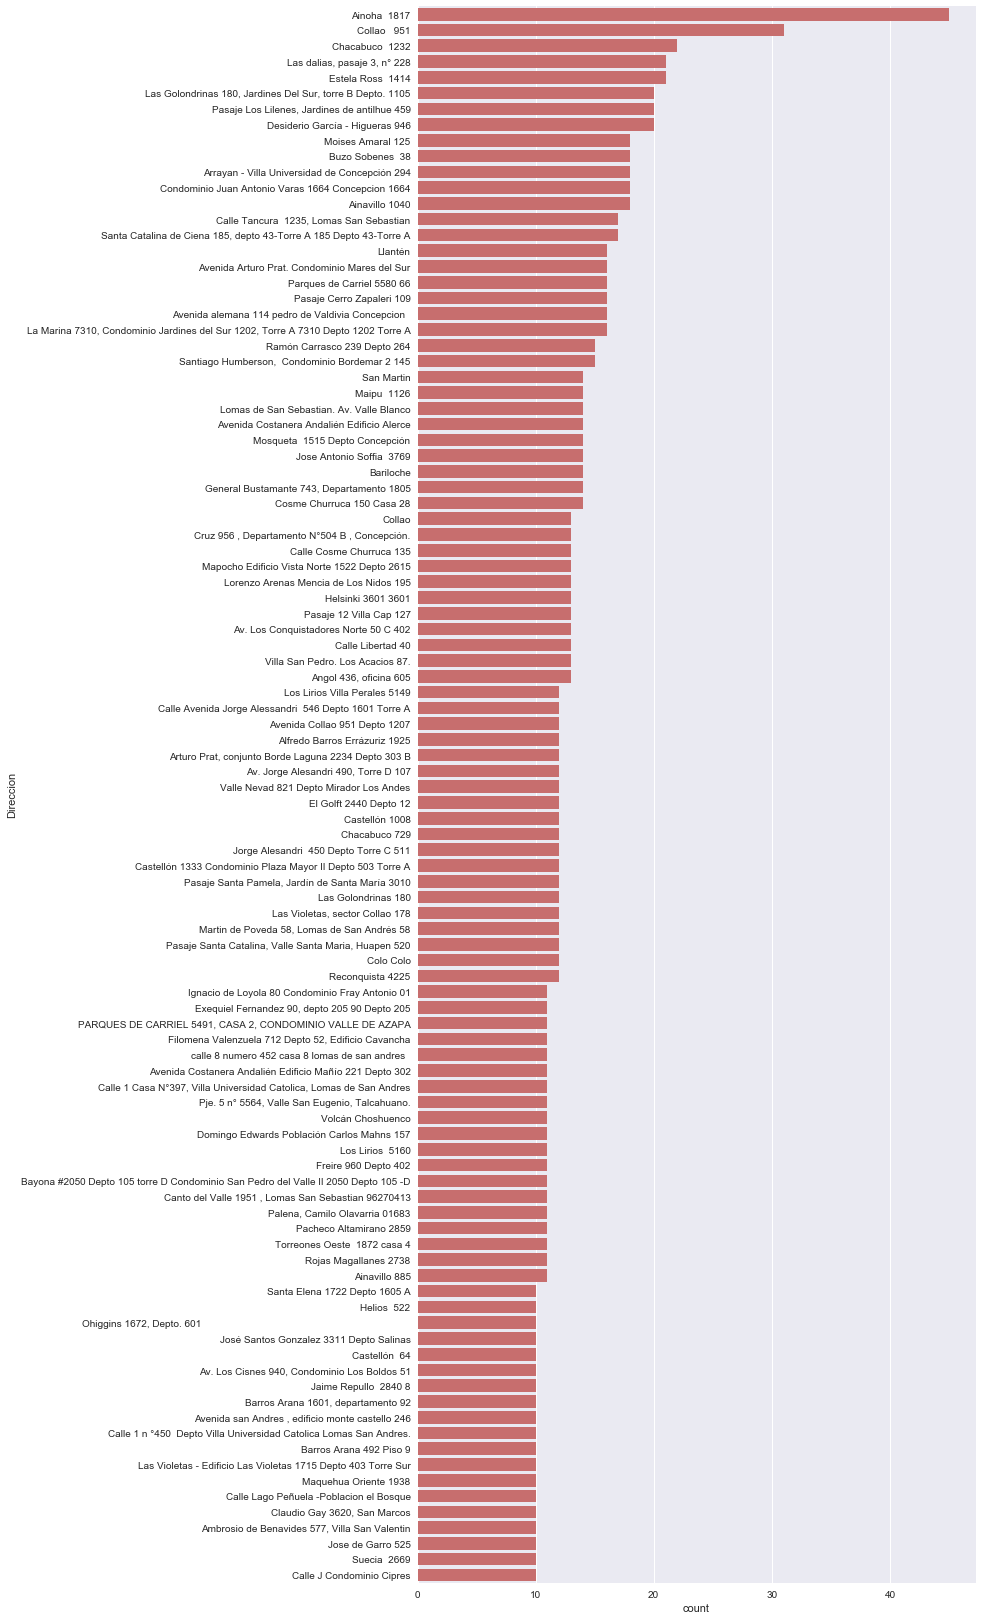

In [52]:
print(cot_mod['Direccion'].isnull().sum())
print(cot_mod['Direccion'].nunique())
f = plt.figure(figsize=(10,29))
ver_atributo_categorico(cot_mod,'Direccion', log=False, lim=100, limit=True)

In [53]:
mask = (cot_mod['Direccion'].str.len() < 7)
print(cot_mod[mask]['Direccion'].shape)
print(cot_mod[mask]['Direccion'])

(32,)
333        ....
448      Collao
449      Collao
450      Collao
596           .
749      schaub
1738     Collao
1739     Collao
1741     Collao
1683      Colon
2613       Avda
6523     bayona
6524     bayona
6531     bayona
9457     bayona
9530      Maipu
9565      Maipu
9568      Maipu
9569      Maipu
9575      Maipu
9812     Collao
9813     Collao
10202    Collao
10203    Collao
10204    Collao
10205    Collao
10334     Angol
10354     Angol
10453    Collao
10479    ......
2409       22 0
2496       22 0
Name: Direccion, dtype: object


In [54]:
print(cot_mod[cot_mod['Direccion'].isnull()].shape)
cot_mod['Direccion'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Direccion'].isnull()].shape)

to_replace = ['.', '......']

cot_mod['Direccion'].replace(
    to_replace,
    'Sin Información', inplace=True, regex=False
)

to_replace = ['\xa0']
cot_mod['Direccion'].replace(
    to_replace,
    '', inplace=True, regex=True
)


(11384, 46)
(0, 46)


0
1285


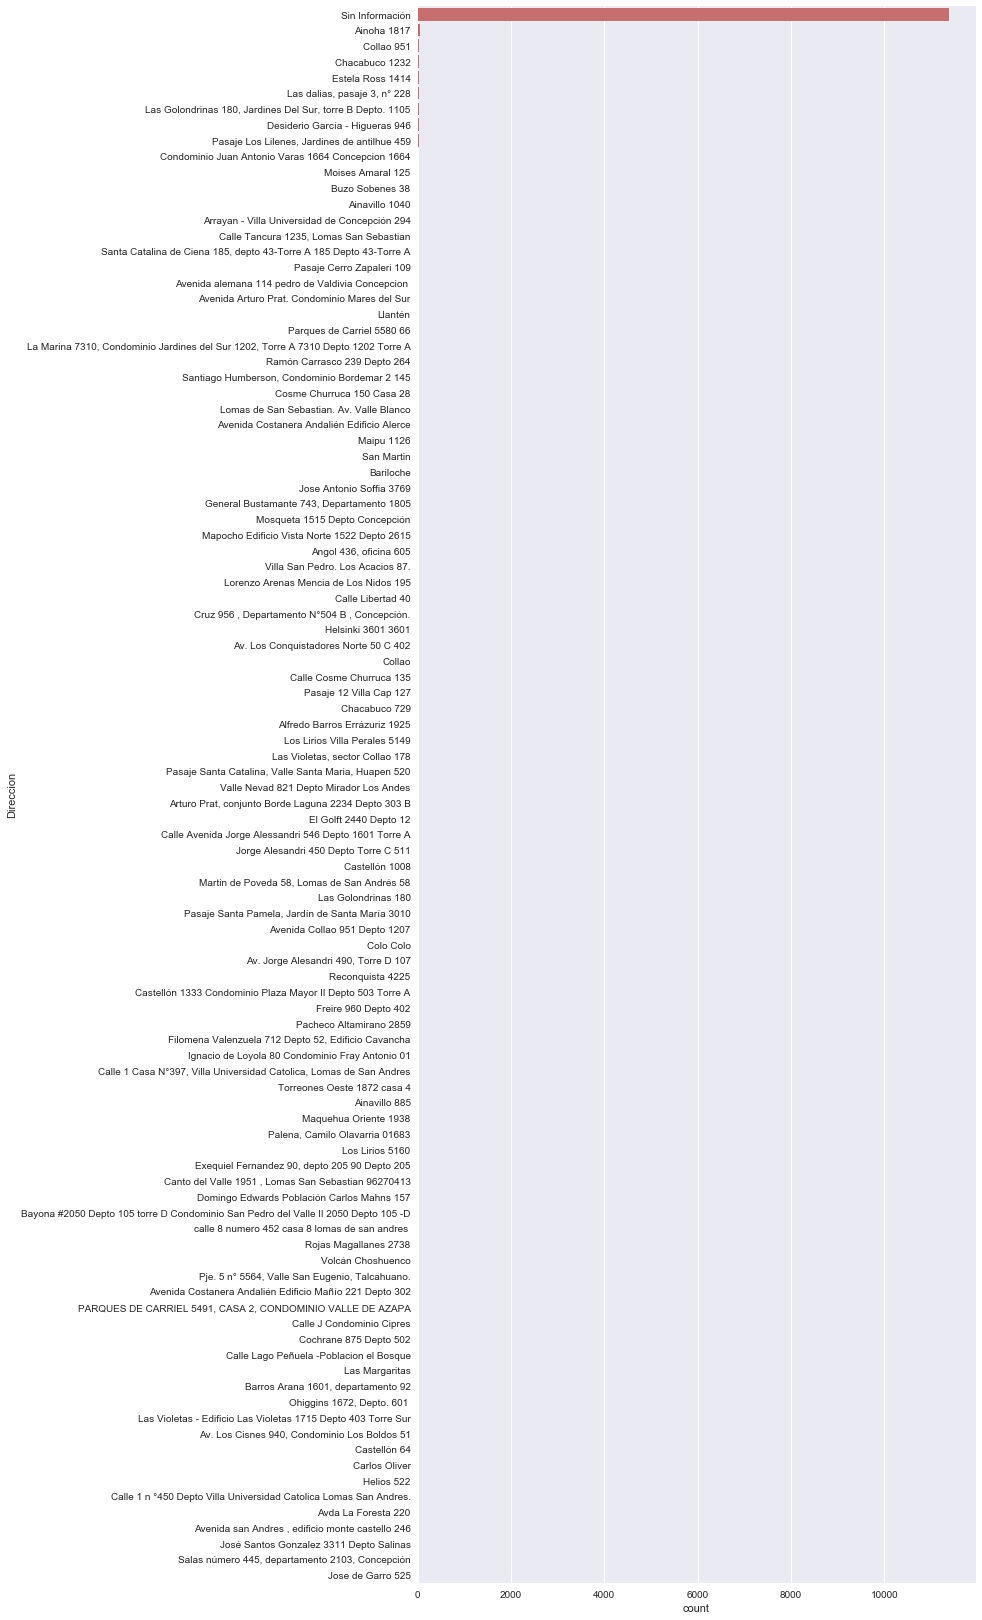

In [55]:
print(cot_mod['Direccion'].isnull().sum())
print(cot_mod['Direccion'].nunique())
f = plt.figure(figsize=(10,29))
ver_atributo_categorico(cot_mod,'Direccion', log=False, lim=100, limit=True)

### 1.2.22 Nombre

2481 ['Nelda Del Carmen', 'Cecilia', 'Yeni', 'Maria Mercedes', 'John Rodrigo', 'Zarah', 'Helena', 'Carlos', 'Leslie Andrea', 'Consuelo Ivonne', 'Fabiola Andrea', 'Maria de la Luz', 'Carlos Alberto', 'Alejandro Antonio', 'Cesar Antonio', 'Jose Eduardo', 'Guido Arcides', 'Pilar Andrea', 'Robinson Antonio', 'Marcos Alex', 'Hector', 'María josé', 'Rodolfo', 'Erwin Alejandro', 'Enzo Antonio', 'Ana María', 'Patricio Bladimir', 'Gabriel Alejandro', 'Anibal Antonio', 'Cristian', 'Antonella', 'Claudio', 'Pia', 'Pamela', 'Ktty Alejandra', 'Anselmo', 'Camila', 'Francisco', 'Vanesa', 'Carmen', 'Luis', 'Nicolas', 'Teresa Del Carmen', 'Maria Alejandra', 'Carolina', 'Patricia Angelica', 'Javier Israel', 'Gerardo Andrés', 'Gianinna Fatme', 'Osvaldo Nicolás', 'Claudia', 'Henry', 'Gloria Celina Fernanda', 'Sindy', 'Jordan Sebastian', 'Patricio', 'Alejandra', 'Julia del Carmen', 'Eduardo Fernando', 'Sonia Del Rosario', 'Dante', 'Douglas', 'Joaquin', 'Cynthia Andrea', 'Jean Paul', 'Pedro Eugenio', 'David'

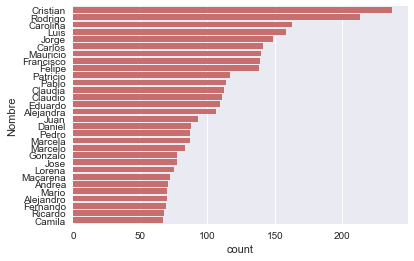

In [56]:
ver_atributo_categorico(cot_all,'Nombre', log=True,limit = True, lim=30)

In [57]:
mask = (cot_mod['Nombre'].str.len() < 3)
print(cot_mod[mask]['Nombre'].shape)
print(cot_mod[mask]['Nombre'])

(4,)
1538     -
1539     .
1540     -
319     Li
Name: Nombre, dtype: object


In [58]:
print(cot_mod[cot_mod['Nombre'].isnull()].shape)
cot_mod['Nombre'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Nombre'].isnull()].shape)

to_replace = ['-', '.']

cot_mod['Nombre'].replace(
    to_replace,
    'Sin Información', inplace=True, regex=False
)

to_replace = ['\xa0']
cot_mod['Nombre'].replace(
    to_replace,
    '', inplace=True, regex=True
)


(0, 46)
(0, 46)


0
2478


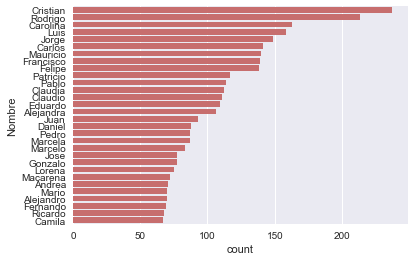

In [59]:
print(cot_mod['Nombre'].isnull().sum())
print(cot_mod['Nombre'].nunique())
ver_atributo_categorico(cot_mod,'Nombre', limit = True, lim=30)

### 1.2.23 Apellido 1

1866 ['Rojas', 'Sepulveda', 'Burgos', 'Torres', 'Fuentes', 'Lobos', 'Villouta', 'Santa María', 'Espinoza', 'Salazar', 'Moreno', 'Polidori', 'Cofre', 'Mardones', 'Soto', 'Paredes', 'Silva', 'Aguilera', 'Reyes', 'Ambiado', 'Gajardo', 'Merino', 'Vejar', 'Daza', 'Lizama', 'Valdes', 'Espinosa', 'Gonzalez', 'Sánchez', 'Gattini', 'Meriño', 'Gutierrez', 'Pincheira', 'Arriagada', 'Garcés', 'Esparza', 'Zamorano', 'Hidalgo', 'Peñailillo', 'Cea', 'Riffo', 'Gaete', 'Jorquera', 'Medina', 'Alarcon', 'Urzua', 'Polanco', 'Osorio', 'Contreras', 'Rebolledo', 'Lopez', 'Garcia', 'Sagredo', 'Uribe', 'Garrido', 'Ordenes', 'Escobar', 'Cifuentes', 'Scarlazetta', 'Inzunza', 'Sanhueza', 'courdurier', 'Cadenas', 'Aranguiz', 'Moraga', 'Garate', 'Belmar', 'Gómez', 'Pache', 'Zagal', 'Bobadilla', 'Figueroa', 'Vega', 'Barriga', 'Sandoval', 'Alcerreca', 'Friedl', 'Arroqui', nan, 'Diaz', 'Gomez', 'Guzman', 'Collao', 'Castro', 'Donoso', 'Chappuzeau', 'Victoriano', 'Castillo', 'Quezada', 'Vivanco', 'Bustos', 'Chavez', 'Na

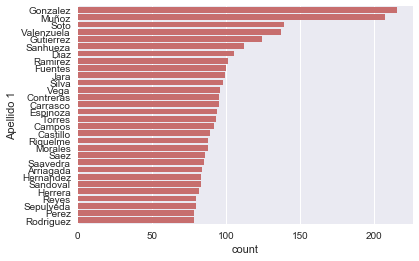

In [60]:
ver_atributo_categorico(cot_mod,'Apellido 1', log=True,limit = True, lim=30)

39
1865


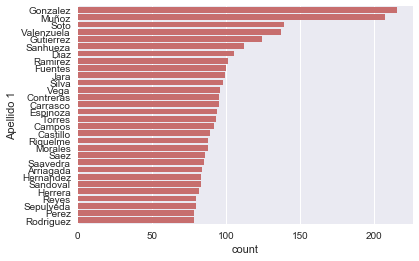

In [61]:
print(cot_mod['Apellido 1'].isnull().sum())
print(cot_mod['Apellido 1'].nunique())
ver_atributo_categorico(cot_mod,'Apellido 1', limit = True, lim=30)

In [62]:
mask = (cot_mod['Apellido 1'].str.len() < 3)
print(cot_mod[mask]['Apellido 1'].shape)
print(cot_mod[mask]['Apellido 1'])

(12,)
418     RC
1539     .
3460     .
4644     .
9006    Li
9007    Li
9939    Li
9940    Li
9941    Li
9942    Li
9943    Li
319     Ma
Name: Apellido 1, dtype: object


In [63]:
print(cot_mod[cot_mod['Apellido 1'].isnull()].shape)
cot_mod['Apellido 1'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Apellido 1'].isnull()].shape)

to_replace = ['-', '.']

cot_mod['Apellido 1'].replace(
    to_replace,
    'Sin Información', inplace=True, regex=False
)

to_replace = ['\xa0']
cot_mod['Apellido 1'].replace(
    to_replace,
    '', inplace=True, regex=True
)


(39, 46)
(0, 46)


0
1865


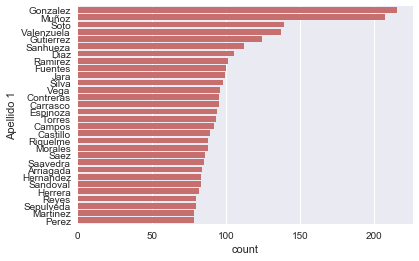

In [64]:
print(cot_mod['Apellido 1'].isnull().sum())
print(cot_mod['Apellido 1'].nunique())
ver_atributo_categorico(cot_mod,'Apellido 1', limit = True, lim=30)

### 1.2.23 Apellido 2

1666 ['Ulloa', 'Torres', 'Manriquez', 'Martinez', 'Gajardo', 'l', '.', 'Campos', 'Fica', 'Pineda', 'Erle', 'Vega', 'Casanova', 'Villegas', 'Herrera', 'Rodriguez', 'Lopez', 'Oliva', 'Cabezas', 'Figueroa', 'Lobos', 'Sanchez', 'Becerra', 'Reyes', 'Miranda', 'Vergara', 'Marianjel', 'Acuña', '*', 'Paredes', 'Larenas', 'Seguek', 'Olivares', '-', 'Guzman', 'Molina', 'Opazo', 'Vilugrón', '..', 'Esparza', 'Vivanco', 'Silva', 'Brañas', 'Quiroga', 'Mora', 'Rojas', 'Nuñez', 'Lazo', 'Ortiz', 'Sandoval', 'Höger', 'Araya', 'Ramirez', 'Cadenas', 'Vera', 'Contreras', 'Hoffmann', 'Cartes', 'Mahuzier', 'Salaberri', 'Hernandez', 'Flores', 'Ilufin', 'Sorensen', 'Romero', 'Jara', 'Suazo', 'Orellana', 'Navarrete', 'Roman', 'Pinto', 'Cottet', 'Irribarra', 'Lecaros', nan, 'Mella', 'Arevalo', 'Aguilera', 'Rios', 'Bolados', 'Vallejos', 'Maldonado', 'Sanchéz', 'Neira', 'Castillo', 'carter', 'Bobadilla', 'Ortega', 'Avello', 'Carmona', 'Carvallo', 'Valenzuela', 'Revello', 'Adonis', 'Martínez', 'Cifuentes', 'Cabrera

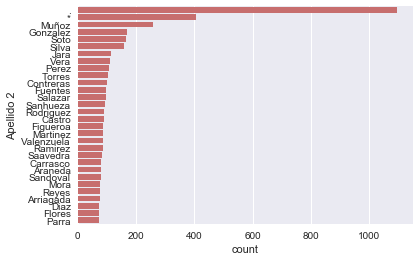

In [65]:
ver_atributo_categorico(cot_mod,'Apellido 2', log=True,limit = True, lim=30)

407
1665


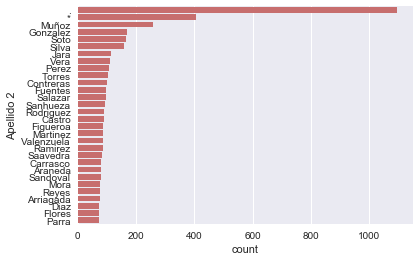

In [66]:
print(cot_mod['Apellido 2'].isnull().sum())
print(cot_mod['Apellido 2'].nunique())
ver_atributo_categorico(cot_mod,'Apellido 2', limit = True, lim=30)

In [67]:
mask = (cot_mod['Apellido 2'].str.len() < 4)
print(cot_mod[mask]['Apellido 2'].shape)
print(cot_mod[mask]['Apellido 2'].tolist())

(1915,)
['l', '.', '.', '.', 'l', '*', '*', '*', '*', '.', '.', '-', '.', '..', '-', '-', '-', '*', '*', '*', '.', '.', '.', '-', '-', '-', '-', '.', '.', 'C', 'C', 'C', 'L', '.', '-', '-', '-', '-', '-', '-', '.', '.', '-', '-', '-', '.', '.', '.', '.', '.', '.', '.', '.', 'A', '*', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'S.', 'S.', 'S.', '.', '.', '.', 'I.', 'I.', 'I.', '.', '.', '.', 'R.', 'R.', 'G', 'G', 'L.', 'P.', 'T.', 'T.', 'T.', '.', '.', '.', '*', '.', '.', '.', '.', '.', '.', '.', 'L', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '*', '*', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '*', '*', '*', '*', '.', '.', '.', 'K', 'K', 'K', '.', '.', '.', '.', 'G.', 'G.', 'G.', 'G.', 'G.', 'G.', 'G.', 'G.', 'G.', 'G.

In [68]:
print(cot_mod[cot_mod['Apellido 2'].isnull()].shape)
cot_mod['Apellido 2'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Apellido 2'].isnull()].shape)

to_replace = ['-', '.', '..', '...', '*', '+', 'mmm']


cot_mod['Apellido 2'].replace(
    to_replace,
    'Sin Información', inplace=True, regex=False
)

(407, 46)
(0, 46)


0
1659


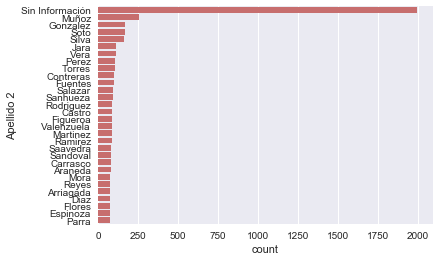

In [69]:
print(cot_mod['Apellido 2'].isnull().sum())
print(cot_mod['Apellido 2'].nunique())
ver_atributo_categorico(cot_mod,'Apellido 2', limit = True, lim=30)

### 1.2.24 Telefono

14598
590


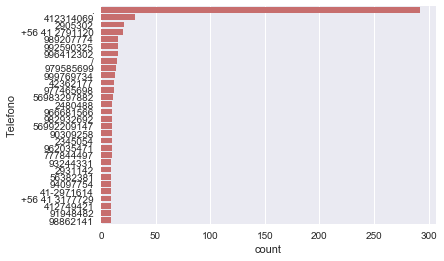

In [70]:
print(cot_mod['Telefono'].isnull().sum())
print(cot_mod['Telefono'].nunique())
ver_atributo_categorico(cot_mod,'Telefono', limit = True, lim=30)

In [71]:
mask = (cot_mod['Telefono'].str.len() < 4)
print(cot_mod[mask]['Telefono'].shape)
print(cot_mod[mask]['Telefono'].tolist())

(314,)
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.

In [72]:
print(cot_mod[cot_mod['Telefono'].isnull()].shape)
cot_mod['Telefono'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Telefono'].isnull()].shape)

to_replace = ['-', '.', '..', '...', '*', '+', 'mmm', '/', 'x']


cot_mod['Telefono'].replace(
    to_replace,
    'Sin Información', inplace=True, regex=False
)

to_replace = ['\xa0']
cot_mod['Telefono'].replace(
    to_replace,
    '', inplace=True, regex=True
)


(14598, 46)
(0, 46)


0
587


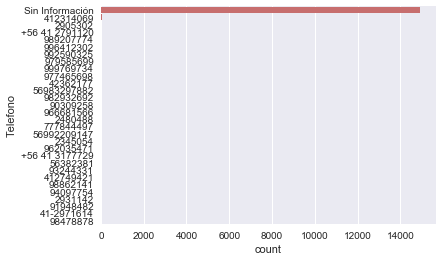

In [73]:
print(cot_mod['Telefono'].isnull().sum())
print(cot_mod['Telefono'].nunique())
ver_atributo_categorico(cot_mod,'Telefono', limit = True, lim=30)

### 1.2.25 Celular

38
6037
6038 [953748134, 76374699, 968441156, 2990590, 981372543, 90834457, 958295551, 995072841, 92449494, 942522023, 984192601, 98836621, 956181171, 85480235, 92493350, 968960554, 991280936, 988894560, 94007891, 956282212, 991299568, 988289650, 979575691, 95209394, 993118503, 88305206, 98873258, 95123765, 999684600, 962374072, 93206658, 98446361, 982314411, 987367733, 9981556548, 52080367, 76694924, 994698200, 981496410, 78995130, 950702404, 93090821, 2225841, 964427332, 994486955, 57568731, 981987470, 992953522, 97955039, 975361247, 74540483, 998279335, 987690273, 982085008, 77934502, 990938143, 998472754, 95990362, 974771402, 974878745, 950196206, 982347427, 964328618, 991390292, 961611186, 65991253, 98717377, 981385833, 942051491, 998847907, 942132618, 996412302, 956787113, '+56 9 61227693', 998950598, 99697471, 86651069, 982788710, 95395290, 82344634, 993443523, 89711239, 99999999, 99496404, '+56 9 75181074', 956675683, 990604760, 92749284, 968989297, 99356039, 98760877, 82995455

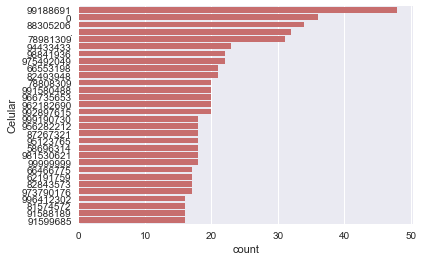

In [74]:
print(cot_mod['Celular'].isnull().sum())
print(cot_mod['Celular'].nunique())
ver_atributo_categorico(cot_mod,  'Celular', log=True, limit = True, lim=30)

In [75]:
mask = (cot_mod['Celular'].str.len() < 6)
print(cot_mod[mask]['Celular'].shape)
print(cot_mod[mask]['Celular'].tolist())

(36,)
['.', '...', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'xxxxx', '-', '...', '.', '.', '.', '.']


In [76]:
print(cot_mod[cot_mod['Celular'].isnull()].shape)
cot_mod['Celular'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Celular'].isnull()].shape)

to_replace = ['-', '.', '..', '...', 
              '*', '+', 'mmm', '/', 'x', 
              '...................', '...........', 'xxxxx']

cot_mod['Celular'].replace(
    to_replace,
    'Sin Información', inplace=True, regex=False
)

to_replace = ['\xa0']
cot_mod['Celular'].replace(
    to_replace,
    '', inplace=True, regex=True
)


(38, 46)
(0, 46)


0
6032


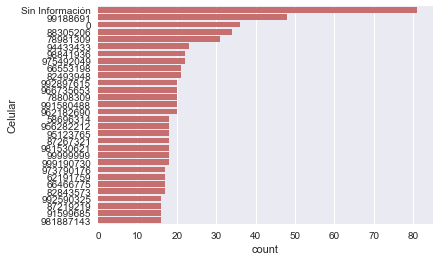

In [77]:
print(cot_mod['Celular'].isnull().sum())
print(cot_mod['Celular'].nunique())
ver_atributo_categorico(cot_mod, 'Celular', limit = True, lim=30)

### 1.2.26 Nombre Completo

0
6179
6179 ['Nelda Del Carmen Rojas Ulloa', 'Cecilia Sepulveda Torres', 'Yeni Burgos Manriquez', 'Maria Torres Martinez', 'John Rodrigo Fuentes Gajardo', 'Zarah Lobos l', 'Helena Villouta .', 'Carlos Santa María .', 'Leslie Andrea Espinoza Campos', 'Consuelo Ivonne Salazar Fica', 'Fabiola Andrea Moreno Pineda', 'Maria de la Luz Polidori Erle', 'Carlos Alberto Cofre Vega', 'Alejandro Antonio Mardones Casanova', 'Cesar Antonio Soto Villegas', 'Jose Eduardo Paredes Herrera', 'Guido Arcides Silva Rodriguez', 'Pilar Andrea Aguilera Lopez', 'Robinson Antonio Reyes Oliva', 'Marcos Alex \xa0Ambiado Cabezas', 'Hector Gajardo Figueroa', 'María josé Merino Lobos', 'Rodolfo \xa0Bejar Sanchez', 'Erwin Alejandro Daza Becerra', 'Enzo Antonio Lizama Reyes', 'Ana María Valdes Miranda', 'Patricio Bladimir Espinosa Vergara', 'Gabriel Alejandro Gonzalez Marianjel', 'Anibal Antonio \xa0Sánchez Acuña', 'Cristian Vejar *', 'Antonella Gattini *', 'Claudio Meriño .', 'Pia Gutierrez Paredes', 'Pamela Pincheira

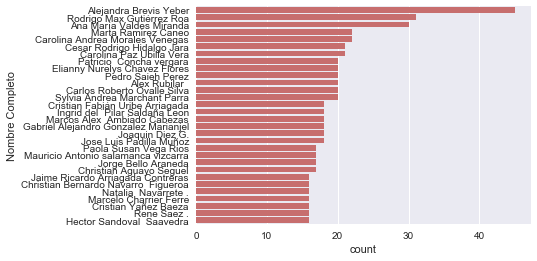

In [78]:
print(cot_mod['Nombre Completo'].isnull().sum())
print(cot_mod['Nombre Completo'].nunique())
ver_atributo_categorico(cot_mod,  'Nombre Completo', log=True, limit = True, lim=30)

0
6179


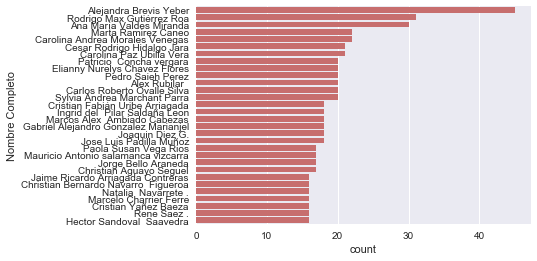

In [79]:
print(cot_mod['Nombre Completo'].isnull().sum())
print(cot_mod['Nombre Completo'].nunique())
ver_atributo_categorico(cot_mod,  'Nombre Completo', log=False, limit = True, lim=30)

In [80]:
mask = (cot_mod['Nombre Completo'].str.len() < 10)
print(cot_mod[mask]['Nombre Completo'].shape)
print(cot_mod[mask]['Nombre Completo'].tolist())

(8,)
['- \xa0', '. . .', '- \xa0', 'Ana Claro', 'Wenjin Li', 'Wenjin Li', 'Li Ma .', 'Ana Claro']


In [81]:
print(cot_mod[cot_mod['Nombre Completo'].isnull()].shape)
cot_mod['Nombre Completo'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Nombre Completo'].isnull()].shape)

to_replace = ['-', '.', '..', '...', 
              '*', '+', 'mmm', '/', 'x', 
              '- \xa0', '. . .', 'xxxxx']

cot_mod['Nombre Completo'].replace(
    to_replace,
    'Sin Información', inplace=True, regex=False
)

to_replace = ['\xa0']
cot_mod['Nombre Completo'].replace(
    to_replace,
    '', inplace=True, regex=True
)

(0, 46)
(0, 46)


0
6176


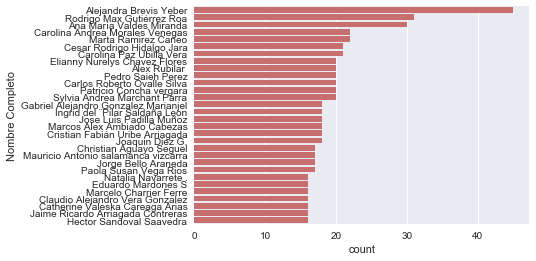

In [82]:
print(cot_mod['Nombre Completo'].isnull().sum())
print(cot_mod['Nombre Completo'].nunique())
ver_atributo_categorico(cot_mod,  'Nombre Completo', log=False, limit = True, lim=30)

### 1.2.26 Sexo

In [83]:
print(cot_mod[cot_mod['Sexo'].isnull()].shape)
cot_mod['Sexo'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Sexo'].isnull()].shape)

(1869, 46)
(0, 46)


### 1.2.26 Giro

16559
20
21 [nan, 'Transporte de carga por carretera', 'Importadora y Comercializadora', 'Inversiones', 'Seguros', 'Comercializadora de aluminios y vidrios', 'Inmobiliaria', 'Servicios', 'Servicios Medicos', 'Inmobiliario', 'Ingenieria', 'Imv Cia LTDA.', 'Inmobiliaria Divesa ltda.', 'comercializadora', 'Obras Civiles', 'Constructora', 'comercializadora utiles domesticos', 'Sociedad de Inversion', 'Sociedad de Inversiones', 'industrial', 'TRASPORTE']


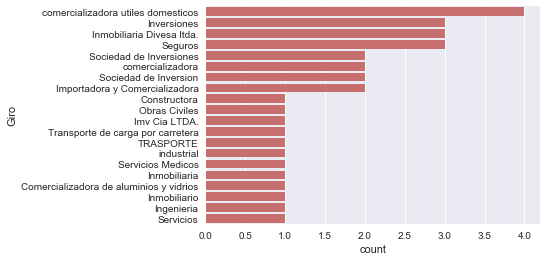

In [84]:
print(cot_mod['Giro'].isnull().sum())
print(cot_mod['Giro'].nunique())
ver_atributo_categorico(cot_mod,'Giro', log=True, limit = True, lim=30)

In [85]:
print(cot_mod[cot_mod['Giro'].isnull()].shape)
cot_mod['Giro'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Giro'].isnull()].shape)

(16559, 46)
(0, 46)


### 1.2.26 Situacion Laboral

12795
3
4 [nan, 'Sin Información', 'Dependiente', 'Independiente']


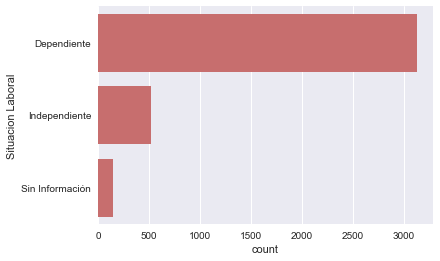

In [86]:
print(cot_all['Situacion Laboral'].isnull().sum())
print(cot_all['Situacion Laboral'].nunique())
ver_atributo_categorico(cot_all,'Situacion Laboral', log=True)

In [87]:
print(cot_mod[cot_mod['Situacion Laboral'].isnull()].shape)
cot_mod['Situacion Laboral'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Situacion Laboral'].isnull()].shape)

(12795, 46)
(0, 46)


0
3
3 ['Sin Información', 'Dependiente', 'Independiente']


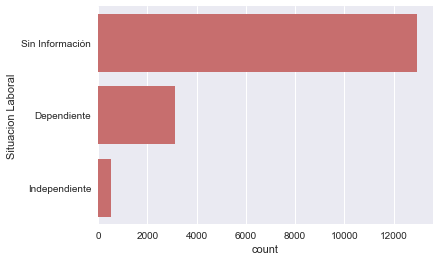

In [88]:
print(cot_mod['Situacion Laboral'].isnull().sum())
print(cot_mod['Situacion Laboral'].nunique())
ver_atributo_categorico(cot_mod,'Situacion Laboral', log=True)

### 1.2.26 Rango Edad

1980
7
8 ['41-50', '31-40', 'Sin Información', '20-30', '51-60', nan, '61+', '15-19']


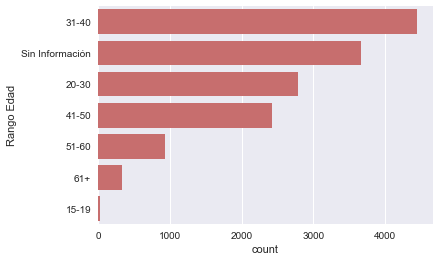

In [89]:
print(cot_mod['Rango Edad'].isnull().sum())
print(cot_mod['Rango Edad'].nunique())
ver_atributo_categorico(cot_mod,'Rango Edad', log=True)

In [90]:
print(cot_mod[cot_mod['Rango Edad'].isnull()].shape)
cot_mod['Rango Edad'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Rango Edad'].isnull()].shape)

(1980, 46)
(0, 46)


0
7
7 ['41-50', '31-40', 'Sin Información', '20-30', '51-60', '61+', '15-19']


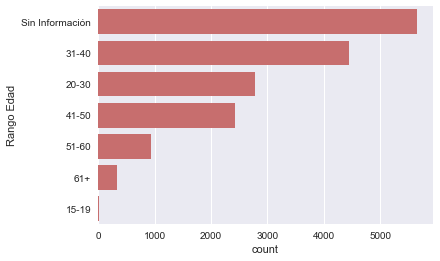

In [91]:
print(cot_mod['Rango Edad'].isnull().sum())
print(cot_mod['Rango Edad'].nunique())
ver_atributo_categorico(cot_mod,'Rango Edad', log=True)

### 1.2.26 Fecha Nacimiento

12701
840
841 [None, -613440000000000000, 167097600000000000, 1471478400000000000, 437011200000000000, -93052800000000000, 637200000000000000, -154569600000000000, 586310400000000000, 285206400000000000, -473731200000000000, 1502582400000000000, 512092800000000000, 104371200000000000, 482025600000000000, 489715200000000000, 586656000000000000, -524016000000000000, 498096000000000000, 649641600000000000, -706233600000000000, 460080000000000000, 365126400000000000, 562896000000000000, 257126400000000000, -555120000000000000, 367286400000000000, 504835200000000000, -89510400000000000, 323481600000000000, 445910400000000000, -212544000000000000, 594086400000000000, 343008000000000000, -121564800000000000, 49420800000000000, 695865600000000000, -140486400000000000, 348796800000000000, -236563200000000000, 431654400000000000, 1461801600000000000, -57801600000000000, -103075200000000000, 1493337600000000000, 592790400000000000, 550022400000000000, 92448000000000000, 691113600000000000, 599270

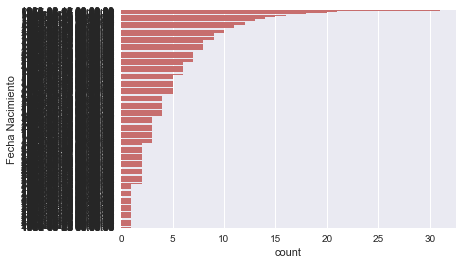

In [92]:
print(cot_mod['Fecha Nacimiento'].isnull().sum())
print(cot_mod['Fecha Nacimiento'].nunique())
ver_atributo_categorico(cot_mod,'Fecha Nacimiento', log=True)

### 1.2.26 Valor Final Venta

In [93]:
print(cot_mod[cot_mod['Valor Final Venta'].isnull()].shape)
print(cot_mod['Valor Final Venta'].nunique())
# ver_atributo_categorico(cot_mod,'Valor Final Venta', log=False)

(44, 46)
2539


In [94]:
print(cot_mod[cot_mod['Valor Final Venta'].isnull()].shape)
cot_mod['Valor Final Venta'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Valor Final Venta'].isnull()].shape)

(44, 46)
(0, 46)


### 1.2.26 Descuentos

In [95]:
print(cot_mod[cot_mod['Descuentos'].isnull()].shape)
print(cot_mod['Descuentos'].nunique())

(44, 46)
339


In [96]:
print(cot_mod[cot_mod['Descuentos'].isnull()].shape)
cot_mod['Descuentos'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Descuentos'].isnull()].shape)

(44, 46)
(0, 46)


### 1.2.26 Nacionalidad

(11744, 46)
8
9 [nan, 'Chilena', 'Venezolana', 'Colombiana', 'Alemana', 'Sin Información', 'Extranjera', 'Boliviana', 'China']


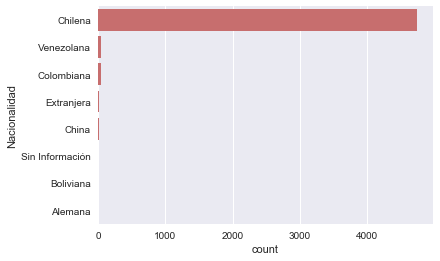

In [97]:
print(cot_mod[cot_mod['Nacionalidad'].isnull()].shape)
print(cot_mod['Nacionalidad'].nunique())
ver_atributo_categorico(cot_mod,'Nacionalidad', log=True)

In [98]:
print(cot_mod[cot_mod['Nacionalidad'].isnull()].shape)
cot_mod['Nacionalidad'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Nacionalidad'].isnull()].shape)

(11744, 46)
(0, 46)


### 1.2.26 Productos

In [99]:
print(cot_mod[cot_mod['Productos'].isnull()].shape)
print(cot_mod['Productos'].nunique())
# ver_atributo_categorico(cot_mod,'Nacionalidad', log=False)

(83, 46)
3534


In [100]:
print(cot_mod[cot_mod['Productos'].isnull()].shape)
cot_mod['Productos'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Productos'].isnull()].shape)

(83, 46)
(0, 46)


### 1.2.26 Presencial

(2027, 46)
2
3 ['Si', 'No', nan]


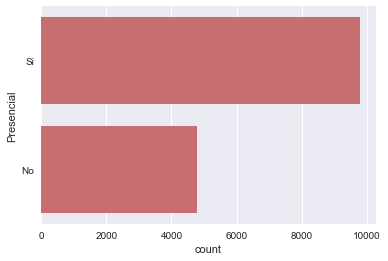

In [101]:
print(cot_mod[cot_mod['Presencial'].isnull()].shape)
print(cot_mod['Presencial'].nunique())
ver_atributo_categorico(cot_mod,'Presencial', log=True)

In [102]:
print(cot_mod[cot_mod['Presencial'].isnull()].shape)
cot_mod['Presencial'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Presencial'].isnull()].shape)

(2027, 46)
(0, 46)


### 1.2.26 Remoto

(3310, 46)
2
3 ['No', 'Si', nan]


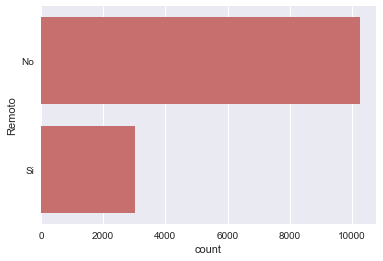

In [103]:
print(cot_mod[cot_mod['Remoto'].isnull()].shape)
print(cot_mod['Remoto'].nunique())
ver_atributo_categorico(cot_mod,'Remoto', log=True)

In [104]:
print(cot_mod[cot_mod['Remoto'].isnull()].shape)
cot_mod['Remoto'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Remoto'].isnull()].shape)

(3310, 46)
(0, 46)


### 1.2.26 Total Productos

In [105]:
print(cot_mod[cot_mod['Total Productos'].isnull()].shape)
print(cot_mod['Total Productos'].nunique())
# ver_atributo_categorico(cot_mod, 'Total Productos', log=False)

(30, 46)
2195


In [106]:
print(cot_mod[cot_mod['Total Productos'].isnull()].shape)
cot_mod['Total Productos'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Total Productos'].isnull()].shape)

(30, 46)
(0, 46)


### 1.2.26 Correo Electronico

In [107]:
print(cot_mod[cot_mod['Correo Electronico'].isnull()].shape)
print(cot_mod['Correo Electronico'].nunique())
# ver_atributo_categorico(cot_mod, 'Total Productos', log=False)

(5, 46)
6082


In [108]:
print(cot_mod[cot_mod['Correo Electronico'].isnull()].shape)
cot_mod['Correo Electronico'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Correo Electronico'].isnull()].shape)

(5, 46)
(0, 46)


### 1.2.26 Tipo Cliente

In [109]:
print(cot_mod[cot_mod['Tipo Cliente'].isnull()].shape)
print(cot_mod['Tipo Cliente'].nunique())
# ver_atributo_categorico(cot_mod, 'Total Productos', log=False)

(1, 46)
2


In [110]:
print(cot_mod[cot_mod['Tipo Cliente'].isnull()].shape)
cot_mod['Tipo Cliente'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Tipo Cliente'].isnull()].shape)

(1, 46)
(0, 46)


### 1.2.26 Razon Social

In [111]:
print(cot_mod[cot_mod['Razon Social'].isnull()].shape)
print(cot_mod['Razon Social'].nunique())
# ver_atributo_categorico(cot_mod, 'Total Productos', log=False)

(16552, 46)
23


In [112]:
print(cot_mod[cot_mod['Razon Social'].isnull()].shape)
cot_mod['Razon Social'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Razon Social'].isnull()].shape)

(16552, 46)
(0, 46)


### 1.2.26 Tipo de Medio

In [113]:
print(cot_mod[cot_mod['Tipo de Medio'].isnull()].shape)
print(cot_mod['Tipo de Medio'].nunique())
# ver_atributo_categorico(cot_mod, 'Total Productos', log=False)

(532, 46)
31


In [114]:
print(cot_mod[cot_mod['Tipo de Medio'].isnull()].shape)
cot_mod['Tipo de Medio'].fillna('Sin Información', inplace=True)
print(cot_mod[cot_mod['Tipo de Medio'].isnull()].shape)

(532, 46)
(0, 46)


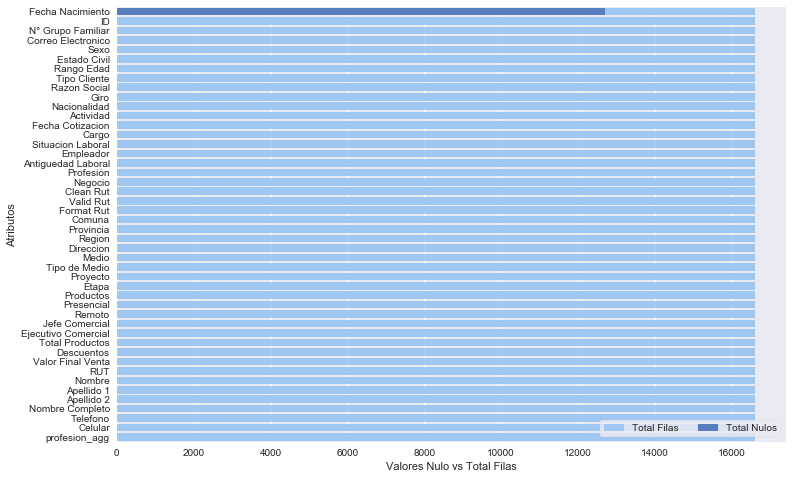

In [115]:
df = cot_mod.copy()
null_columns = df.columns[df.isnull().any()]
nulos = df[null_columns].isnull().sum()

#view all columns with its null count
null_columns = df.columns
null_df =  df.shape[0] - df.count()

null_df = pd.DataFrame({'Total':null_df,'Etiquetas':null_columns})

columnas = null_columns.copy()
filas = [df.shape[0]] * len(null_columns)

totales = pd.DataFrame({'Total':filas,'Etiquetas':columnas})

f, ax = plt.subplots(figsize=(12, 8))

sb.set_color_codes("pastel")
sb.barplot(data=totales.sort_values(by='Total',ascending=False), x='Total', y='Etiquetas',color="b",label="Total Filas")

sb.set_color_codes("muted")
sb.barplot(data=null_df.sort_values(by='Total',ascending=False), x='Total', y='Etiquetas',color="b",label="Total Nulos")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Atributos", xlabel="Valores Nulo vs Total Filas")
# sb.despine(left=True, bottom=True)
f.savefig("..\\img\\cot_all_attributes.png")

[Text(0,0.5,'Atributos'), Text(0.5,0,'Valores Nulo vs Total Filas')]

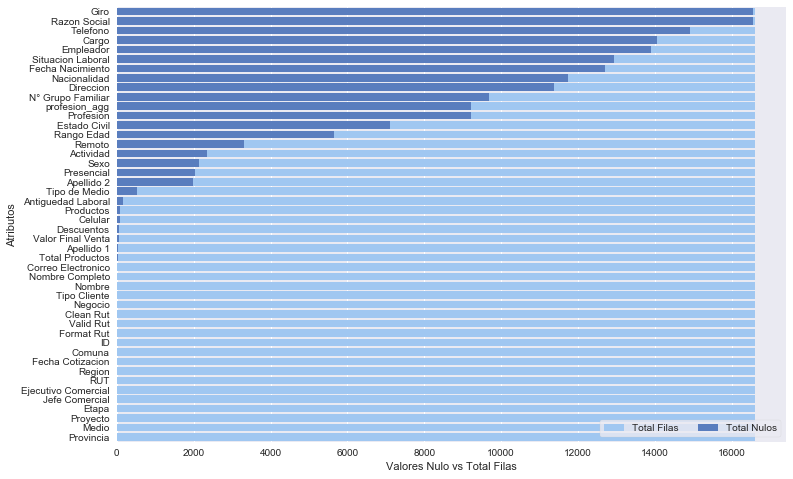

In [116]:
df = cot_mod.copy()
df.replace(['Sin Información'], np.nan, inplace=True)

null_columns = df.columns[df.isnull().any()]
nulos = df[null_columns].isnull().sum()

#view all columns with its null count
null_columns = df.columns
null_df =  df.shape[0] - df.count()

null_df = pd.DataFrame({'Total':null_df,'Etiquetas':null_columns})

columnas = null_columns.copy()
filas = [df.shape[0]] * len(null_columns)

totales = pd.DataFrame({'Total':filas,'Etiquetas':columnas})

f, ax = plt.subplots(figsize=(12, 8))

sb.set_color_codes("pastel")
sb.barplot(data=totales.sort_values(by='Total',ascending=False), x='Total', y='Etiquetas',color="b",label="Total Filas")

sb.set_color_codes("muted")
sb.barplot(data=null_df.sort_values(by='Total',ascending=False), x='Total', y='Etiquetas',color="b",label="Total Nulos")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Atributos", xlabel="Valores Nulo vs Total Filas")
# sb.despine(left=True, bottom=True)

In [117]:
cot_mod.replace(['Sin Información'], np.nan, inplace=True)

In [118]:
cot_mod.to_csv("..\\..\\Datos\\working\\cotizaciones_cleaned.csv")
cot_mod.to_excel("..\\..\\Datos\\working\\cotizaciones_cleaned.xlsx")

In [119]:
# De las personas quienes entregaron todos los datos

In [120]:
iterator_all = 0
people_all = []
iterator_any = 0
for group, frame in  df.groupby('Format Rut'):
    
    cond_all = (
        (~(frame['Cargo'].isnull()).all()) &
        (~(frame['Estado Civil'].isnull()).all()) &
        (~(frame['Situacion Laboral'].isnull()).all()) &
        (~(frame['Rango Edad'].isnull()).all()) &
        (~(frame['Profesión'].isnull()).all()) &
        (~(frame['Actividad'].isnull()).all()) &
        (~(frame['Direccion'].isnull()).all()) &
        (~(frame['N° Grupo Familiar'].isnull()).all()) &
        (~(frame['Actividad'].isnull()).all()) &
        (~(frame['Sexo'].isnull()).all())
    )
    
    if cond_all:
        iterator_all += 1
        people_all.append(group)
    
    cond_any = (
        (~(frame['Cargo'].isnull()).any()) &
        (~(frame['Estado Civil'].isnull()).any()) &
        (~(frame['Situacion Laboral'].isnull()).any()) &
        (~(frame['Rango Edad'].isnull()).any()) &
        (~(frame['Profesión'].isnull()).any()) &
        (~(frame['Actividad'].isnull()).any()) &
        (~(frame['Direccion'].isnull()).any()) &
        (~(frame['N° Grupo Familiar'].isnull()).any()) &
        (~(frame['Actividad'].isnull()).any()) &
        (~(frame['Sexo'].isnull()).any())
    )
    
    if cond_any:
        iterator_any += 1

print(iterator_all, iterator_any)

275 275


In [121]:
tmp = df[df['Format Rut'].isin(people_all)]
tmp

,ID,Fecha Cotizacion,Medio,Tipo de Medio,Proyecto,Etapa,Productos,Presencial,Remoto,Jefe Comercial,...,Cargo,Situacion Laboral,Empleador,Antiguedad Laboral,Profesión,Negocio,Clean Rut,Valid Rut,Format Rut,profesion_agg
11,112677,2017-08-11 16:07:35.000,RECONTACTO,Recontacto,Altos del Valle,ADV - Etapa 1,"Bod-02,Est-26",No,No,Alejandra Pooley Flores,...,Matrona,Dependiente,NaN,1.0,Matrona,True,10076241-2,True,10.076.241-2,Matrona
14,112688,2017-08-11 17:07:27.000,RECONTACTO,Recontacto,Altos del Valle,ADV - Etapa 1,Est-60,No,No,Alejandra Pooley Flores,...,Biotecnologo,Dependiente,BioForest S.A.,2.0,Ingeniería en Biotecnología,True,17346494-0,True,17.346.494-0,Ingeniería en Biotecnología
15,112701,2017-08-11 18:08:43.000,RECORRIDO POR EL SECTOR,Paseo,Altos del Valle,ADV - Etapa 1,"Est-61,Est-03",Si,No,Alejandra Pooley Flores,...,Metereologo,Dependiente,DGAC,29.0,Otro,True,10065290-0,True,10.065.290-0,Otro
16,112705,2017-08-11 18:16:08.000,RECONTACTO,Recontacto,Altos del Valle,ADV - Etapa 1,Est-62,No,No,Alejandra Pooley Flores,...,Ingeniero de mantención,Dependiente,ACCIONA agua,1.0,Ingeniero Eléctrico,True,16763770-1,True,16.763.770-1,Ingeniero Eléctrico
21,112720,2017-08-11 19:04:41.000,RECORRIDO POR EL SECTOR,Paseo,Altos del Valle,ADV - Etapa 1,Est-58,Si,No,Alejandra Pooley Flores,...,Vendedor Técnico,Dependiente,Soc. Transportes Maritimo Service Ltda,2.0,Mecánico Industrial,True,12524132-8,True,12.524.132-8,Mecánico Industrial
24,112906,2017-08-14 15:38:41.000,RECORRIDO POR EL SECTOR,Paseo,Altos del Valle,ADV - Etapa 1,Est-59,Si,No,Alejandra Pooley Flores,...,Enfermeria,Dependiente,Traumatologico,6.0,Enfermería,True,15912017-1,True,15.912.017-1,Enfermería
30,113112,2017-08-16 18:58:40.000,RECORRIDO POR EL SECTOR,Paseo,Altos del Valle,ADV - Etapa 1,"TB-201,Est-44",Si,No,Alejandra Pooley Flores,...,Jefe de costos y presupuestos,Dependiente,Forestal Celco,37.0,Contador Auditor,False,6782798-8,True,6.782.798-8,Contador Auditor
31,113125,2017-08-16 19:44:54.000,RECORRIDO POR EL SECTOR,Paseo,Altos del Valle,ADV - Etapa 1,"TA-703,Est-01",Si,No,Alejandra Pooley Flores,...,Jefe área de repuestos,Dependiente,Caufmann,3.0,Ingeniero Comercial,False,16152006-3,True,16.152.006-3,Ingeniero Comercial
32,113139,2017-08-17 11:06:43.757,INTERNET,Web Aitue,Altos del Valle,ADV - Etapa 1,TB-201,No,No,Alejandra Pooley Flores,...,Supervisor Inmobiliario.,Dependiente,Inmobiliaria Los Pellines S.A.,1.0,Ingeniero en Construcción,False,17592674-7,True,17.592.674-7,Ingeniero en Construcción
40,113269,2017-08-18 18:55:37.000,RECONTACTO,Recontacto,Altos del Valle,ADV - Etapa 1,TA-503,Si,No,Alejandra Pooley Flores,...,Jefe área de repuestos,Dependiente,Caufmann,3.0,Ingeniero Comercial,False,16152006-3,True,16.152.006-3,Ingeniero Comercial


In [122]:
tmp = df[df['Format Rut'].isin(people_all)]
print(tmp[tmp.Negocio == True].shape)
print(tmp[tmp.Negocio == False].shape)

(507, 46)
(934, 46)
